In [1]:
! pip install kaggle
!pip install nltk
!pip install demoji
!pip install lime
!pip install tweet-preprocessor
#https://www.kaggle.com/code/ravishekhartiwari123/explainable-ai-on-a-nlp-lstm-model-with-lime/edit
#https://www.kaggle.com/code/alikmondal/twitter-hate-speech-detection
#https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283858 sha256=57f6b1f014e8b161dd93b6e2946594388ac7dcc2aaef4c7b77bab932556eeedc
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 /content/.kaggle/kaggle.json
! kaggle datasets download vkrahul/twitter-hate-speech
! unzip /content/twitter-hate-speech.zip 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory
  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 155MB/s]
Archive:  /content/twitter-hate-speech.zip
  inflating: test_tweets_anuFYb8.csv  
  inflating: train_E6oV3lV.csv       
--2022-11-18 12:01:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-18 12:01:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-18 12:01:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanfor

In [3]:
%matplotlib inline

import os
import re
import nltk
import lime
import demoji
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import preprocessor as p
from lime import lime_text
from tensorflow import keras
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.stem import PorterStemmer
from tensorflow.keras import layers
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from keras.wrappers.scikit_learn import KerasClassifier
from lime.lime_text import IndexedString,IndexedCharacters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")


In [ ]:
nltk.download('all')
demoji.download_codes()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [ ]:
train = pd.read_csv("/content/train_E6oV3lV.csv")
test = pd.read_csv("/content/test_tweets_anuFYb8.csv")

In [ ]:

def upsample(dataframe):
  
  print("Before Upsampling::",train['label'].value_counts())
  train_majority = dataframe[dataframe.label==0]
  train_minority = dataframe[dataframe.label==1]
  train_minority_upsampled = resample(train_minority, 
                                      replace=True,    
                                        n_samples=len(train_majority),   
                                        random_state=123)
  
  train_upsampled = pd.concat([train_minority_upsampled, train_majority])
  print("Sfter Upsampling::",train['label'].value_counts())
  return(train_upsampled)


train_upsampled=upsample(train)

Before Upsampling:: 0    29720
1     2242
Name: label, dtype: int64
Sfter Upsampling:: 0    29720
1     2242
Name: label, dtype: int64


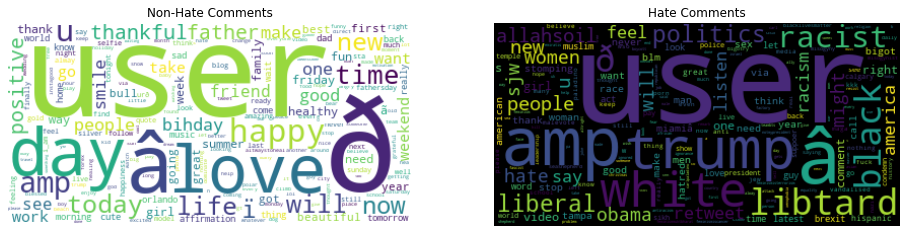

In [ ]:


fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train['tweet'][train.label == 0])
text_neg = " ".join(train['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

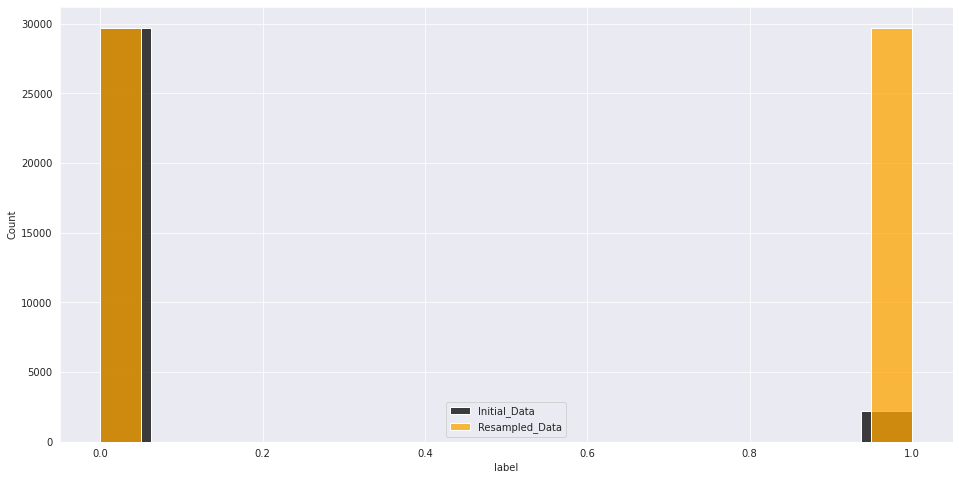

In [ ]:


plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

In [ ]:
class preproceessing():
    
    def __init__(self,x,y,algo='BOG',pad='backward',max_features=512):
      self.x=x
      self.y=y
      self.algo=algo
      self.glove_vec='/content/glove.6B.50d.txt'
      self.pad=pad
      self.max_features=max_features
      

      self.govedata=self.read_glove_vector()

    def noemoji(self, data):
        dem = demoji.findall(str(data))
        for item in dem.keys():
          data = data.replace(item,'')
        return(data)

    def remove_punctuation(self,data):
        return(re.sub(r'[^\w\s]', '', str(data)))
    
    def preprocessing_twitter(self,data):
        data1=p.clean(str(data))
        return(data1)
    
    def tokenise_data(self,data):
        return(word_tokenize(data))

    def remove_stopwords(self,data):
        stop_words = set(stopwords.words('english'))
        return ([i for i in data if not i.lower() in stop_words])

    
    def stemming(self,data):
        ps = PorterStemmer()
        data1=""
        for w in data:
          data1=data1+" "+ps.stem(w)
        return(data1)

    def bog(self,data):
        vectorizer = CountVectorizer(max_features=512)
        bog_data=vectorizer.fit_transform(data)
        return([bog_data.toarray(),vectorizer.get_feature_names_out(),vectorizer])

    def tf_idf(self,data):
        vectorizer = TfidfVectorizer(max_features=512)
        tfidf_data=vectorizer.fit_transform(data)
        return([tfidf_data.toarray(),vectorizer.get_feature_names_out(),vectorizer])
    
    def read_glove_vector(self):
        with open(self.glove_vec, 'r', encoding='UTF-8') as f:
            words = set()
            word_to_vec_map = {}
            for line in f:
                w_line = line.split()
                curr_word = w_line[0]
                word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
        
        return word_to_vec_map

    def padding(self,data,pad):
      len_list=len(data)
      data_real=[]
      if pad=='backward':
          padding_nedded=self.max_features-len_list
          for i in range(0,512):
            if i < len_list:
              data_real.append(data[i])
            else:
              data_real.append(0)
      elif pad=='forward':
        padding_nedded=self.max_features-len_list
        for i in range(0,512):
          if i < padding_nedded:
            data_real.append(0)
          else:
            data_real.append(data[i])
      #print("shape pad ini::",np.asarray(data_real).shape)
      return(np.asarray(data_real))

    def wrapper(self):
      data={
             "X":self.x,
             "Y":self.y
           }
      new_data = pd.DataFrame.from_dict(data)

      

      if self.algo=='BOG':
        preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming)
        data_return=self.bog(preprocessed.values)
        return(data_return,self.y)
      elif self.algo=='TFIDF':
        preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming)
        data_return=self.tf_idf(preprocessed.values)
        return(data_return,self.y)
      elif self.algo=='GLOVE':
          data_glove=[]
          self.govedata=self.read_glove_vector()
          
          preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming).apply(self.tokenise_data)
          return (preprocessed,self.y)
          


class preprocess_test(preproceessing):

  def __init__(self,x):
      self.x=x
  def test_set(self):
        data={
             "X":self.x
            
           }
        new_data = pd.DataFrame.from_dict(data)
        preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming)
        return(preprocessed)
  def test_setglove(self):
        data={
             "X":self.x
            
           }
        new_data = pd.DataFrame.from_dict(data)
        preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming).apply(self.tokenise_data)
        return(preprocessed)


In [ ]:
#functions 

import math
import numpy as np
class preprocessingSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set,algo="GLOVE",pad='backward',max_features=512,batch_size=32):
        
        self.algo=algo
        self.set=set
        self.batch_size = batch_size
        self.max_features=max_features
        self.pad=pad

        if self.algo !='GLOVE':
            self.obj_preprocessing=preproceessing(x_set, y_set,self.algo,self.max_features)
            data,label=self.obj_preprocessing.wrapper()
            self.x= list(data[0])
            self.featuresname=data[1]
            self.vec=data[2]
            self.y=list(label)
        if self.algo =='GLOVE':
           self.obj_preprocessing=preproceessing(x_set, y_set,self.algo,self.max_features)
           self.govedata=self.obj_preprocessing.read_glove_vector()

           data,label=self.obj_preprocessing.wrapper()
           data_sentence=[]
           data_glove=[]
           for index,sentences in enumerate(data):
               data_words=[]
            
               for words in sentences:
              
                   embedding_vector = self.govedata.get(words)
                   if embedding_vector is not None:
                       for p in  embedding_vector:
                           data_words.append(p)
                   else:
                        for p in range(0,10):
                            data_words.append(0)
                
                   data_sentence=[l for l in data_words]
               data_glove.append(self.obj_preprocessing.padding(np.asarray(data_sentence),self.pad))
             
           self.x=data_glove
           self.y=label

           
            
           
           
    def test_pre(self,data):
        obj=preprocess_test(data)
        if self.algo !='GLOVE':
      
            
            datapreprocessed=obj.test_set()
            Features=self.vec.transform(datapreprocessed)
            return(Features.toarray())

        else:
            datapreprocessed=obj.test_setglove()
            data_sentence=[]
            data_glove=[]
            for index,sentences in enumerate(data):
                data_words=[]
            
                for words in sentences:
              
                    embedding_vector = self.govedata.get(words)
                    if embedding_vector is not None:
                        for p in  embedding_vector:
                           data_words.append(p)
                    else:
                         for p in range(0,10):
                             data_words.append(0)
                
                    data_sentence=[l for l in data_words]
                data_glove.append(self.obj_preprocessing.padding(np.asarray(data_sentence),self.pad))
             
            return(data_glove)
         



    
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    

    def __getitem__(self, idx):

        batch_x = self.x[idx * self.batch_size:(idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x),np.array(batch_y)
    
    def return_all(self):

      
      return self.x,self.y
       
        
       
 
    

In [ ]:

batch_size = 128
max_features = 512
tf.random.set_seed(42)

def create_model(max_features=512):
    
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(max_features, 128)(inputs)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(25, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.AUC()])
    return model

In [ ]:
dataset_train=preprocessingSequence(train['tweet'],train['label'],'TFIDF')
#dataset_test=dataset_train.test_pre(test['tweet'])

In [ ]:
history=create_model().fit(dataset_train,epochs=10)

Epoch 1/10
999/999 [==============================] - 44s 41ms/step - loss: 0.2572 - accuracy: 0.9299 - auc_8: 0.5000
Epoch 2/10
999/999 [==============================] - 43s 43ms/step - loss: 0.2546 - accuracy: 0.9299 - auc_8: 0.5075
Epoch 3/10
999/999 [==============================] - 42s 42ms/step - loss: 0.2545 - accuracy: 0.9299 - auc_8: 0.4904
Epoch 4/10
999/999 [==============================] - 42s 42ms/step - loss: 0.2544 - accuracy: 0.9299 - auc_8: 0.4939
Epoch 5/10
999/999 [==============================] - 40s 40ms/step - loss: 0.2544 - accuracy: 0.9299 - auc_8: 0.5025
Epoch 6/10
999/999 [==============================] - 41s 41ms/step - loss: 0.2543 - accuracy: 0.9299 - auc_8: 0.5028
Epoch 7/10
999/999 [==============================] - 43s 43ms/step - loss: 0.2545 - accuracy: 0.9299 - auc_8: 0.4913
Epoch 8/10
999/999 [==============================] - 41s 41ms/step - loss: 0.2544 - accuracy: 0.9299 - auc_8: 0.5039
Epoch 9/10
999/999 [==============================] - 40

In [ ]:
def predict_lime(array=[test['tweet'].iloc[34]],class_number=2):
  
  preprocessed=dataset_train.test_pre(array)
  probability=create_model().predict(np.asarray(preprocessed))
  probability=[[np.asarray(i[0]), np.asarray(1-i[0])  ]for i in probability]
  probability=np.asarray(probability).reshape((len(array),class_number))
  print(probability)
  return(probability)

a=predict_lime()

1/1 [==============================] - 1s 671ms/step
[[0.5024609 0.4975391]]


<h1>For Refrence</h1> 
<br>
Reshape for Lime 
<br>
<code>
print(a)
print(type(a))
print(a.shape)
a1=np.asarray([[121212, 12122]])
s1=a1.reshape((1,2))
print(s1)
</code>

<br>
SKLEARN Keras wrapper
<br>
<code>
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32,max_features=max_features, verbose=1)
pipeline=make_pipeline(sklearn_lstm)
data_train,label_train=dataset_train.return_all()
pipeline.fit(np.asarray(data_train),np.asarray(label_train))
probability=pipeline.predict_proba(np.asarray(preprocessed))
</code>

In [ ]:
class_names=["Not Hate Speech", "Hate Speech"]
explainer=lime.lime_text.LimeTextExplainer(class_names=class_names)

In [ ]:
exp = explainer.explain_instance(test['tweet'][34],  predict_lime, num_features=5000, num_samples=50)


2/2 [==============================] - 1s 23ms/step
[[0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747]
 [0.50529253 0.49470747

In [ ]:
#For BOG
exp.show_in_notebook(text=test['tweet'][34] )

In [ ]:
#For gLOVE
exp.show_in_notebook(text=test['tweet'][34] )

In [ ]:
#FOR tfidf
exp.show_in_notebook(text=test['tweet'][34] )